<a href="https://colab.research.google.com/github/gamecicn/ECE661_FinalProject/blob/main/notebooks%5Cquestion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pthflops
!pip install torchsummary

  Created wheel for pthflops: filename=pthflops-0.4.1-py3-none-any.whl size=10063 sha256=04e311f179a168a22232007654006a9381adc5abdd83043796469fdc81f7cf25
  Stored in directory: /root/.cache/pip/wheels/9c/41/05/475bdaebaaf3a44f25367a8dc0ac9d4b8edbb7f5fa19724c70
Successfully built pthflops


In [1]:
# set working dictionary
import os
import sys
from google.colab import drive

drive.mount('/content/drive')


os.chdir('/content/drive/MyDrive/ECE661/FinalProject')
sys.path.append('/content/drive/MyDrive/ECE661/FinalProject')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime 
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# parameters
RANDOM_SEED = 42

IMG_SIZE = 28
N_CLASSES = 10

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {DEVICE}")

#############################################
# your code here
# construct dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=False, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

Device: cuda


## Check Images

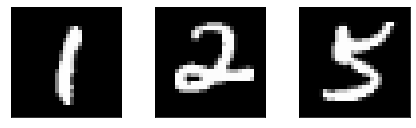

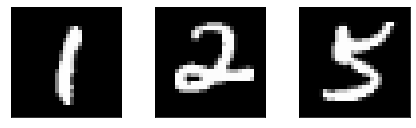

In [ ]:
import matplotlib.pyplot as plt
 
_, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure()
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
fig

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

## LetNet : *Teacher Model*

03:02:33 --- Epoch: 0	Train loss: 0.4685	Valid loss: 0.1781	Train accuracy: 94.21	Valid accuracy: 94.41
03:02:53 --- Epoch: 1	Train loss: 0.1294	Valid loss: 0.1002	Train accuracy: 96.54	Valid accuracy: 96.56
03:03:13 --- Epoch: 2	Train loss: 0.0889	Valid loss: 0.0667	Train accuracy: 97.80	Valid accuracy: 97.75
03:03:34 --- Epoch: 3	Train loss: 0.0678	Valid loss: 0.0653	Train accuracy: 97.94	Valid accuracy: 97.80
03:03:54 --- Epoch: 4	Train loss: 0.0572	Valid loss: 0.0807	Train accuracy: 97.69	Valid accuracy: 97.33
03:04:13 --- Epoch: 5	Train loss: 0.0500	Valid loss: 0.0413	Train accuracy: 98.69	Valid accuracy: 98.74
03:04:33 --- Epoch: 6	Train loss: 0.0419	Valid loss: 0.0424	Train accuracy: 98.99	Valid accuracy: 98.55
03:04:53 --- Epoch: 7	Train loss: 0.0357	Valid loss: 0.0346	Train accuracy: 99.09	Valid accuracy: 98.90
03:05:12 --- Epoch: 8	Train loss: 0.0331	Valid loss: 0.0416	Train accuracy: 99.05	Valid accuracy: 98.74
03:05:32 --- Epoch: 9	Train loss: 0.0287	Valid loss: 0.0346	Trai

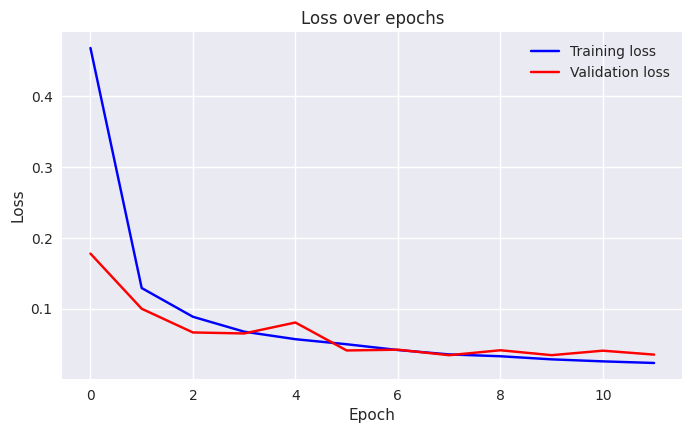

In [14]:

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 6, 5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
 

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

#================================================================================

torch.manual_seed(RANDOM_SEED)

LEARNING_RATE = 0.001
N_EPOCHS = 12

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE)    

## Small Model : *Student Model*

03:51:29 --- Epoch: 0	Train loss: 1.0429	Valid loss: 0.4802	Train accuracy: 85.14	Valid accuracy: 86.02
03:51:48 --- Epoch: 1	Train loss: 0.4485	Valid loss: 0.3782	Train accuracy: 88.04	Valid accuracy: 88.99
03:52:07 --- Epoch: 2	Train loss: 0.3799	Valid loss: 0.3319	Train accuracy: 89.44	Valid accuracy: 90.22
03:52:26 --- Epoch: 3	Train loss: 0.3429	Valid loss: 0.3060	Train accuracy: 90.31	Valid accuracy: 90.98
03:52:45 --- Epoch: 4	Train loss: 0.3178	Valid loss: 0.2882	Train accuracy: 90.70	Valid accuracy: 91.36
03:53:04 --- Epoch: 5	Train loss: 0.2982	Valid loss: 0.2689	Train accuracy: 91.45	Valid accuracy: 91.88
03:53:22 --- Epoch: 6	Train loss: 0.2807	Valid loss: 0.2534	Train accuracy: 91.96	Valid accuracy: 92.19
03:53:43 --- Epoch: 7	Train loss: 0.2664	Valid loss: 0.2463	Train accuracy: 92.21	Valid accuracy: 92.56
03:54:02 --- Epoch: 8	Train loss: 0.2540	Valid loss: 0.2327	Train accuracy: 92.79	Valid accuracy: 92.98
03:54:21 --- Epoch: 9	Train loss: 0.2442	Valid loss: 0.2244	Trai

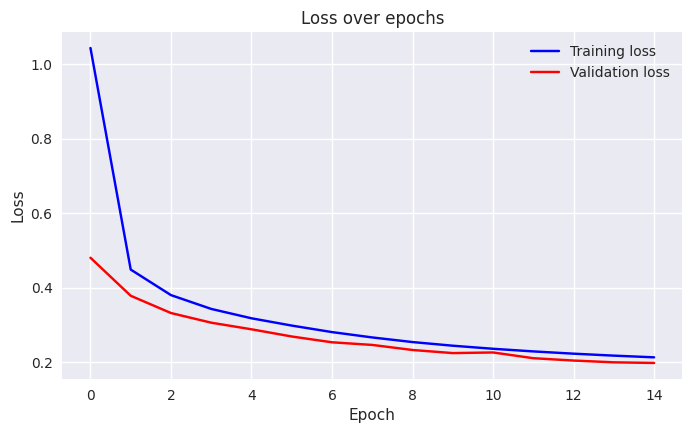

In [16]:
class StudentNet(nn.Module):

    def __init__(self, n_classes):
        super(StudentNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 1, 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(1, 2, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(32, 10),
        )
 

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

# Train 

LEARNING_RATE = 0.001
N_EPOCHS = 15

model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model_s, optimizer, _ = training_loop(model_s, criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE)      

## Compare FLOP

In [13]:
from pthflops import count_ops
from torchsummary import summary

teacher_model = LeNet5(N_CLASSES).to(DEVICE)

summary(teacher_model, (1, 28, 28))
count_ops(teacher_model.model, torch.rand(1,1,28,28).to(DEVICE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

(442358,
 [['_0', 122304],
  ['_1', 9408],
  ['_2', 4704],
  ['_3', 241600],
  ['_4', 3200],
  ['_5', 1600],
  ['_7', 48120],
  ['_8', 240],
  ['_9', 10164],
  ['_10', 168],
  ['_11', 850]])

In [18]:
student_model = StudentNet(N_CLASSES).to(DEVICE)
 
summary(student_model, (1, 28, 28))
count_ops(student_model.model, torch.rand(1,1,28,28).to(DEVICE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              26
              ReLU-2            [-1, 1, 26, 26]               0
         AvgPool2d-3            [-1, 1, 13, 13]               0
            Conv2d-4              [-1, 2, 9, 9]              52
              ReLU-5              [-1, 2, 9, 9]               0
         AvgPool2d-6              [-1, 2, 4, 4]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 408
Trainable params: 408
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
OperationOPS     
---  ------  
_0   17576   
_1  

(24598,
 [['_0', 17576],
  ['_1', 1352],
  ['_2', 676],
  ['_3', 4212],
  ['_4', 324],
  ['_5', 128],
  ['_7', 330]])